# **Carmen Seoane: 26/11/2025**
 Cáculo del **plot de exclusión** simple (sin considerar el modelo de fondo) del **experimento ANAIS-112** con 6 años de exposición

In [1]:
## LIBRERÍAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math
import uproot

In [ ]:
## LIBRERÍAS

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math
import uproot

## CONSTANTES GLOBALES

N_Avogadro=6.02214076*10**23
h_bar=6.582119569e-16
c=2.99792458e8
v_esc = 544 # km/s : Galactic Escape Speed
v_0 = 238 # km/s : Locad Standard of Rest Velocity
v_pec = np.array([11.1, 12.2, 7.3]) # km/s : Peculiar velocity of the Sun
v_sun = np.array([11.1, 12.2+v_0, 7.3]) # km/s : Sun velocity respect to the Galaxy
wimp_density = 0.3 # GeV/cm^3

## DEFINICIÓN DE FUNCIONES

def reduced_mass(m_N,m_WIMP):
    return m_N*m_WIMP/(m_N+m_WIMP) #GeV

def nucleus_mass(A):
    m_n = 0.9315 #GeV
    return A*m_n;

def detector_mass(A):
    return N_Avogadro/A*1000*nucleus_mass(A); #GeV/kg

def momento(m_N, E_R):
    # m_N in GeV
    # E_R in keV
    return np.sqrt(2*m_N*E_R/1000000); #GeV

def j1(x):
    return np.sin(x)/x**2-np.cos(x)/x; #dimensionless

def form_factor(A, E_R):
    m_N = nucleus_mass(A) #GeV
    q = momento (m_N, E_R) # GeV
    R = 1.2*A**(1./3.) #fm
    s = 1 #fm
    R1 = np.sqrt(R**2 - 5*s**2) #fm
    R1 = R1/(h_bar*c*10**(15))*10**9 #GeV^(-1)
    x = q*R1 #dimensionless
    if E_R==0:
        squared_form_factor = 1
    else:
        squared_form_factor = (3*j1(x)/x)**2 * np.exp(-(q**2)*(s/(h_bar*c*10**(15))*10**9)**2) #dimensionless
    return squared_form_factor;

def calculate_v_min(A, E_R, m_WIMP):
    m_N = nucleus_mass(A) # GeV
    mu = reduced_mass(m_N, m_WIMP) # GeV
    v_min = np.sqrt(m_N*E_R/1000000 / (2*mu**2)) # dimensionless
    return v_min

def calculate_v_earth(t):
    v_orb = 29.8 # km/s
    omega = 2*np.pi/365 # d^(-1)
    v_x = v_orb * (0.9941*np.cos(omega*t)-0.00504*np.sin(omega*t))
    v_y = v_orb * (0.1088*np.cos(omega*t)+0.4946*np.sin(omega*t))
    v_z = v_orb * (0.0042*np.cos(omega*t)-0.8677*np.sin(omega*t))
    v = np.array([v_x,v_y,v_z]) # [km/s, km/s, km/s]
    return v;

def eta(A, E_R, t, m_WIMP):
    v_min = calculate_v_min(A, E_R, m_WIMP) ## dimensionless
    v_earth = calculate_v_earth(t) ## [km/s, km/s, km/s]
    v_min = v_min * c/1000 ##km/s

    x = v_min / v_0
    y = np.linalg.norm(v_sun + v_earth) / v_0
    z = v_esc / v_0

    N = erf(z) - 2*z/np.sqrt(np.pi) * np.exp(-z**2)
    factor_comun = 1/(2*y*v_0) * 1/N
    if (0 <= x <= (z-y)):
        eta = factor_comun * ( erf(x+y) - erf(x-y) - (4/np.sqrt(np.pi))*y*np.exp(-z**2) )
    if ((z-y) < x <= (z+y)):
        eta = factor_comun * ( erf(z) - erf(x-y) - (2/np.sqrt(np.pi))*(z+y-x)*np.exp(-z**2) )
    if (x > (z+y)):
        eta = 0
    return eta;

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)
    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf
    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)
    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf
    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def dif_rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
    E=Eee/Q # convert Eee to keV_NR
    mu = reduced_mass(0.9315, mW)
    factor_de_forma = form_factor(A, E)
    eta_val = eta(A, E, t, mW)
    dif_rate = detector_mass(A)*wimp_density/(2*mW*mu**2)*c**2/10*A**2*sigmaSI*factor_de_forma*eta_val/1E6*3600*2 ## cts/keV_NR/kg/d
    dif_rate/=Q
    return dif_rate ## cts/keVee/kg/d

def dif_rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
    rateNa = dif_rate_ee(Eee,t,23,mW,sigmaSI,QNa)
    rateI = dif_rate_ee(Eee,t,127,mW,sigmaSI,QI)
    return (rateNa*23.+rateI*127.)/(23.+127.)

def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = getQFNa(energy_ee)
    qfI = getQFI(energy_ee)
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)])
    return rates.sum()*0.1

def totalRate_NaI_ee_DAMA(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = 0.3
    qfI = 0.09
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qfNa, qfI)
        for e in energy_ee])
    return rates.sum()*0.1

## N de cuentas = ritmo * exposición (m * t)
def numero_cuentas_teo(Eiee,Efee,t,mW,sigmaSI,det):
    retval=totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI)
    exposure=calculate_exposure(det)*12.5 ## kg*day
    retval*=exposure
    return retval

def calculate_exposure(det=0):  ## para el caso de ANAIS-112
    exposure=np.zeros(9)
    exposure[0]=2031.38*12.5
    exposure[1]=2033.20*12.5
    exposure[2]=2029.52*12.5
    exposure[3]=2022.55*12.5
    exposure[4]=2033.01*12.5
    exposure[5]=2030.18*12.5
    exposure[6]=2032.27*12.5 
    exposure[7]=2031.02*12.5
    exposure[8]=2020.29*12.5
    return exposure[det]

def experimental_total_rate_per_detector(energies, diff_rates, Ei=1.0, Ef=6.0):
    mask = (energies >= Ei) & (energies <= Ef)
    integral = np.sum(diff_rates[mask]) * 0.1 ## bineado de 0.1 keV en los histogramas
    return integral

def experimental_number_of_counts(det, energies, diff_rates, Ei=1.0, Ef=6.0):
    exposure = calculate_exposure(det)
    counts = exposure * experimental_total_rate_per_detector(energy_values[det], rate_values[det], Ei, Ef)
    return counts

def N_cuentas_exp(Ei, Ef, energies, rates):
    total_number_of_counts=0
    for i in range(9):
        total_number_of_counts += experimental_number_of_counts(i, energies[i], rates[i], Ei, Ef)
    return total_number_of_counts

file=uproot.open("BEhistos_year123456.root")

## cargo los histogramas dentro del archivo root (hay un histograma por detector)
hists=[file[f"hbea_123456y_D{i}"] for i in range(9)]

rate_values=[]
energy_values=[]

for i in range(9):
    ## al parecer esta función carga los bordes!! no el centro del bin. Lo corrijo abajo
    rates_per_det, edges_per_det = hists[i].to_numpy()
    energies_per_det = 0.5 * (edges_per_det[:-1] + edges_per_det[1:])
    rate_values.append(rates_per_det)
    energy_values.append(energies_per_det)

    ## ventanas en las que quiero calcular el plot de exclusión
E1_i, E1_f = 1.0, 6.0
E2_i, E2_f = 2.0, 6.0

Nexp1 = N_cuentas_exp(E1_i, E1_f, energy_values, rate_values)
Nexp2 = N_cuentas_exp(E2_i, E2_f, energy_values, rate_values)

secciones1 = []
secciones2 = []

## delta (CL)
delta = 1.28 ## 90% CL

for mW in masas:
    
    nTeo1 = 0.0
    nTeo2 = 0.0
    
    for det in range(9):
        nTeo1 += numero_cuentas_teo(E1_i, E1_f, timeAvg, mW, 1.0, det)
        nTeo2 += numero_cuentas_teo(E2_i, E2_f, timeAvg, mW, 1.0, det)
        
    sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
    sigma2 = (Nexp2 + delta * math.sqrt(Nexp2)) / nTeo2
    
    secciones1.append(sigma1)
    secciones2.append(sigma2)

In [2]:
## CONSTANTES GLOBALES

N_Avogadro=6.02214076*10**23
h_bar=6.582119569e-16
c=2.99792458e8
v_esc = 544 # km/s : Galactic Escape Speed
v_0 = 238 # km/s : Locad Standard of Rest Velocity
v_pec = np.array([11.1, 12.2, 7.3]) # km/s : Peculiar velocity of the Sun
v_sun = np.array([11.1, 12.2+v_0, 7.3]) # km/s : Sun velocity respect to the Galaxy
wimp_density = 0.3 # GeV/cm^3

In [3]:
## DEFINICIÓN DE FUNCIONES

def reduced_mass(m_N,m_WIMP):
    return m_N*m_WIMP/(m_N+m_WIMP) #GeV

def nucleus_mass(A):
    m_n = 0.9315 #GeV
    return A*m_n;

def detector_mass(A):
    return N_Avogadro/A*1000*nucleus_mass(A); #GeV/kg

def momento(m_N, E_R):
    # m_N in GeV
    # E_R in keV
    return np.sqrt(2*m_N*E_R/1000000); #GeV

def j1(x):
    return np.sin(x)/x**2-np.cos(x)/x; #dimensionless

def form_factor(A, E_R):
    m_N = nucleus_mass(A) #GeV
    q = momento (m_N, E_R) # GeV
    R = 1.2*A**(1./3.) #fm
    s = 1 #fm
    R1 = np.sqrt(R**2 - 5*s**2) #fm
    R1 = R1/(h_bar*c*10**(15))*10**9 #GeV^(-1)
    x = q*R1 #dimensionless
    if E_R==0:
        squared_form_factor = 1
    else:
        squared_form_factor = (3*j1(x)/x)**2 * np.exp(-(q**2)*(s/(h_bar*c*10**(15))*10**9)**2) #dimensionless
    return squared_form_factor;

def calculate_v_min(A, E_R, m_WIMP):
    m_N = nucleus_mass(A) # GeV
    mu = reduced_mass(m_N, m_WIMP) # GeV
    v_min = np.sqrt(m_N*E_R/1000000 / (2*mu**2)) # dimensionless
    return v_min

def calculate_v_earth(t):
    v_orb = 29.8 # km/s
    omega = 2*np.pi/365 # d^(-1)
    v_x = v_orb * (0.9941*np.cos(omega*t)-0.00504*np.sin(omega*t))
    v_y = v_orb * (0.1088*np.cos(omega*t)+0.4946*np.sin(omega*t))
    v_z = v_orb * (0.0042*np.cos(omega*t)-0.8677*np.sin(omega*t))
    v = np.array([v_x,v_y,v_z]) # [km/s, km/s, km/s]
    return v;

def eta(A, E_R, t, m_WIMP):
    v_min = calculate_v_min(A, E_R, m_WIMP) ## dimensionless
    v_earth = calculate_v_earth(t) ## [km/s, km/s, km/s]
    v_min = v_min * c/1000 ##km/s

    x = v_min / v_0
    y = np.linalg.norm(v_sun + v_earth) / v_0
    z = v_esc / v_0

    N = erf(z) - 2*z/np.sqrt(np.pi) * np.exp(-z**2)
    factor_comun = 1/(2*y*v_0) * 1/N
    if (0 <= x <= (z-y)):
        eta = factor_comun * ( erf(x+y) - erf(x-y) - (4/np.sqrt(np.pi))*y*np.exp(-z**2) )
    if ((z-y) < x <= (z+y)):
        eta = factor_comun * ( erf(z) - erf(x-y) - (2/np.sqrt(np.pi))*(z+y-x)*np.exp(-z**2) )
    if (x > (z+y)):
        eta = 0
    return eta;

## Incluyo el **quenching factor** de Tamara

In [4]:
def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)
    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf
    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)
    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf
    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])
    return y_interp[0] if np.isscalar(ee) else y_interp

## Defino las funciones para **calcular el ritmo esperado** (diferencial y total) dada la **energía en electron equivalent**

In [5]:
def dif_rate_ee(Eee,t,A,mW,sigmaSI, Q=1):
    E=Eee/Q # convert Eee to keV_NR
    mu = reduced_mass(0.9315, mW)
    factor_de_forma = form_factor(A, E)
    eta_val = eta(A, E, t, mW)
    dif_rate = detector_mass(A)*wimp_density/(2*mW*mu**2)*c**2/10*A**2*sigmaSI*factor_de_forma*eta_val/1E6*3600*2 ## cts/keV_NR/kg/d
    dif_rate/=Q
    return dif_rate ## cts/keVee/kg/d

def dif_rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
    rateNa = dif_rate_ee(Eee,t,23,mW,sigmaSI,QNa)
    rateI = dif_rate_ee(Eee,t,127,mW,sigmaSI,QI)
    return (rateNa*23.+rateI*127.)/(23.+127.)

def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = getQFNa(energy_ee)
    qfI = getQFI(energy_ee)
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)])
    return rates.sum()*0.1

def totalRate_NaI_ee_DAMA(Eiee,Efee,t,mW,sigmaSI):
    energy_ee = np.arange(Eiee,Efee,0.1)
    qfNa = 0.3
    qfI = 0.09
    rates = np.array([
        dif_rateNaI_ee(e, t, mW, sigmaSI, qfNa, qfI)
        for e in energy_ee])
    return rates.sum()*0.1

## N de cuentas = ritmo * exposición (m * t)
def numero_cuentas_teo(Eiee,Efee,t,mW,sigmaSI,det):
    retval=totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI)
    exposure=calculate_exposure(det)*12.5 ## kg*day
    retval*=exposure
    return retval

## Cálculo con los datos del **experimento ANAIS-112** (6 años de exposición)

La exposición nos la ha pasado Iván. Notar que el tiempo vivo de cada detector es distinto... Esto al principio no era así, pero a partir de un determinado punto (no sé cuándo) empezaron a eliminar los datos adquiridos cuando se detectaba un aumento notable del ritmo en uno de los detectores

Calcular el número de cuentas experimental es tan fácil como integrar el ritmo diferencial y multiplicarlo por la exposición

In [ ]:
def calculate_exposure(det=0):  ## para el caso de ANAIS-112
    exposure=np.zeros(9)
    exposure[0]=2031.38*12.5
    exposure[1]=2033.20*12.5
    exposure[2]=2029.52*12.5
    exposure[3]=2022.55*12.5
    exposure[4]=2033.01*12.5
    exposure[5]=2030.18*12.5
    exposure[6]=2032.27*12.5 
    exposure[7]=2031.02*12.5
    exposure[8]=2020.29*12.5
    return exposure[det]

def experimental_total_rate_per_detector(energies, diff_rates, Ei=1.0, Ef=6.0):
    mask = (energies >= Ei) & (energies <= Ef)
    integral = np.sum(diff_rates[mask]) * 0.1 ## bineado de 0.1 keV en los histogramas
    return integral

def experimental_number_of_counts(det, energies, diff_rates, Ei=1.0, Ef=6.0):
    exposure = calculate_exposure(det)
    counts = exposure * experimental_total_rate_per_detector(energy_values[det], rate_values[det], Ei, Ef)
    return counts

def N_cuentas_exp(Ei, Ef, energies, rates):
    total_number_of_counts=0
    for i in range(9):
        total_number_of_counts += experimental_number_of_counts(i, energies[i], rates[i], Ei, Ef)
    return total_number_of_counts

Cargo los datos de los 6 años. El archivo root (_"BEhistos_year123456.root"_) lo ha hecho Iván. Para cada detector hay un TH1F con el ritmo en _cuentas/keV/kg/d_ utilizando un bineado de 0.1 keV

In [6]:
file=uproot.open("BEhistos_year123456.root")

## cargo los histogramas dentro del archivo root (hay un histograma por detector)
hists=[file[f"hbea_123456y_D{i}"] for i in range(9)]

rate_values=[]
energy_values=[]

for i in range(9):
    ## al parecer esta función carga los bordes!! no el centro del bin. Lo corrijo abajo
    rates_per_det, edges_per_det = hists[i].to_numpy()
    energies_per_det = 0.5 * (edges_per_det[:-1] + edges_per_det[1:])
    rate_values.append(rates_per_det)
    energy_values.append(energies_per_det)

Ahora ya tenemos todo para calcular el plot de exclusión. Como vamos a hacerlo para el _90% confidence level_, tenemos que tener en cuenta que el número de cuentas dse puede aproximar a una distribución gaussiana, por lo tanto tendremos que calcular la sección eficaz que dé un número de cuentas mayor que:

$N_{exp} + \delta \cdot \sqrt{N_{exp}}$

Para el 90% de confidence level el factor delta es 1.28 (referencia: Particle Data Group)

# PLOT DE EXCLUSIÓN

In [29]:
## ventanas en las que quiero calcular el plot de exclusión
E1_i, E1_f = 1.0, 6.0
E2_i, E2_f = 2.0, 6.0

Nexp1 = N_cuentas_exp(E1_i, E1_f, energy_values, rate_values)
Nexp2 = N_cuentas_exp(E2_i, E2_f, energy_values, rate_values)

secciones1 = []
secciones2 = []

## delta (CL)
delta = 1.28 ## 90% CL

for mW in masas:
    
    nTeo1 = 0.0
    nTeo2 = 0.0
    
    for det in range(9):
        nTeo1 += numero_cuentas_teo(E1_i, E1_f, timeAvg, mW, 1.0, det)
        nTeo2 += numero_cuentas_teo(E2_i, E2_f, timeAvg, mW, 1.0, det)
        
    sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
    sigma2 = (Nexp2 + delta * math.sqrt(Nexp2)) / nTeo2
    
    secciones1.append(sigma1)
    secciones2.append(sigma2)

/tmp/ipykernel_553204/1413230281.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  sigma1 = (Nexp1 + delta * math.sqrt(Nexp1)) / nTeo1
/tmp/ipykernel_553204/1413230281.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  sigma2 = (Nexp2 + delta * math.sqrt(Nexp2)) / nTeo2


In [31]:
## datos de COSINE-100 (Cirian O'Hare github)

m_cosine = np.array([
    4.9640178366735155, 7.427340484719667, 9.90451772034801,
    14.890753234093896, 19.857138578719542, 29.853826189179603,
    49.40262207658599, 59.566214352901035, 69.44910713781213,
    100, 119.99597163578586, 149.62356560944343, 199.52623149688807,
    298.538261891796, 491.6620262745646, 694.4910713781214,
    990.4517720348015, 10000
])

sigma_cosine = np.array([
    6.965251508129022e-40, 1.9289278571925736e-40, 1.1297282209439266e-40,
    4.851472857149282e-41, 1.4173822470471825e-41, 3.967464149927643e-42,
    2.1103254787914668e-42, 2.0436613046299367e-42, 2.1103254787914668e-42,
    2.274454867332229e-42, 2.3739123729349366e-42, 2.9403666412306177e-42,
    3.415523274218115e-42, 5.020459805713681e-42, 8.039045023248604e-42,
    1.156636853678232e-41, 1.5606609009592468e-41, 1.5407505875173104e-40
])

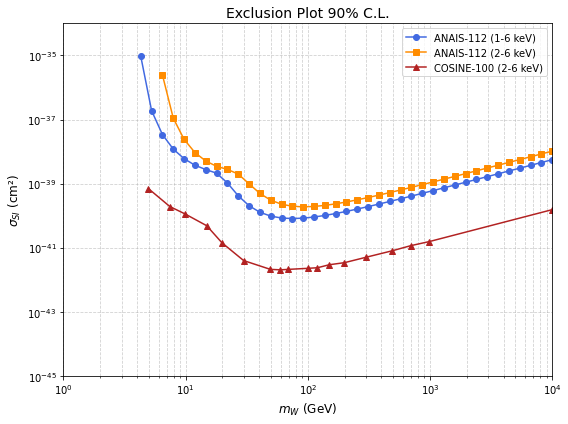

In [33]:
plt.figure(figsize=(8,6))
plt.plot(masas, secciones1, 'o-', color='royalblue', label='ANAIS-112 (1-6 keV)')
plt.plot(masas, secciones2, 's-', color='darkorange', label='ANAIS-112 (2-6 keV)')
plt.plot(m_cosine, sigma_cosine, '^-', color='firebrick', label='COSINE-100 (2-6 keV)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$m_W$ (GeV)', fontsize=12)
plt.ylabel('$\sigma_{SI}$ (cm²)', fontsize=12)
plt.xlim(1.0, 10000)
plt.ylim(1.0e-45, 1.0e-34)
plt.title('Exclusion Plot 90% C.L.', fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("ExclusionPlot.png", dpi=1200, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()